In [2]:
import torch
import wandb
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io
from PIL import Image
from torchvision.io import read_image
import cv2
import glob

In [ ]:
!pip install wandb

In [2]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %ls
!zip -r /content/drive/MyDrive/sec3cv.zip /content/drive/MyDrive/cv_assignment3_colab

In [ ]:
%cd drive/MyDrive/cv_assignment3_colab/
%ls

In [ ]:
import glob
%cd images/test
print(len(glob.glob('*')))
%cd ../../labels/test
print(len(glob.glob('*')))
%cd ../../
%ls

In [ ]:
training_images=[]
training_labels=[]
for image in os.listdir("svhn_yolo/svhn/images/all"):
    training_images.append(cv2.imread("svhn_yolo/svhn/images/all/"+image))

for label in os.listdir("svhn_yolo/svhn/labels/all"):
    a=np.loadtxt("svhn_yolo/svhn/labels/all/"+label)
    training_labels.append(a)
training_data=list(zip(training_images,training_labels))

33402
33402
[[1.         0.38663968 0.53285714 0.10931174 0.62571429]
 [9.         0.50067476 0.54428571 0.12955466 0.62571429]]
(350, 741, 3)
(2, 5)
33402
(350, 741, 3)
(2, 5)
2


In [ ]:
wandb.init(project="CV_assignment_Q3")

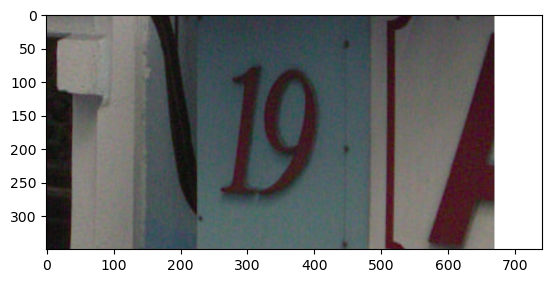

In [ ]:
plt.imshow(training_images[0])
plt.show()

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),
transforms.Resize((224,224)),
transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
class customDataset(Dataset):
    def __init__(self, images, transform=None):
        self.item = images
        self.transform = transform

    def __len__(self):
        return len(self.item)

    def __getitem__(self, idx):
        item = self.item[idx]
        if self.transform:
            item[0] = self.transform(item[0])
        return item

In [ ]:
train_size = int(0.7 * len(training_images))
val_size = int(0.2 * len(training_images))
test_size = len(training_images) - train_size - val_size
training_data=customDataset(training_data)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(training_data, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(0))

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

23381
6680
3341


In [ ]:
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=True)

{2.0: 7395, 5.0: 4845, 3.0: 5870, 1.0: 9831, 9.0: 3235, 6.0: 3988, 0.0: 3441, 7.0: 3974, 4.0: 5227, 8.0: 3532}


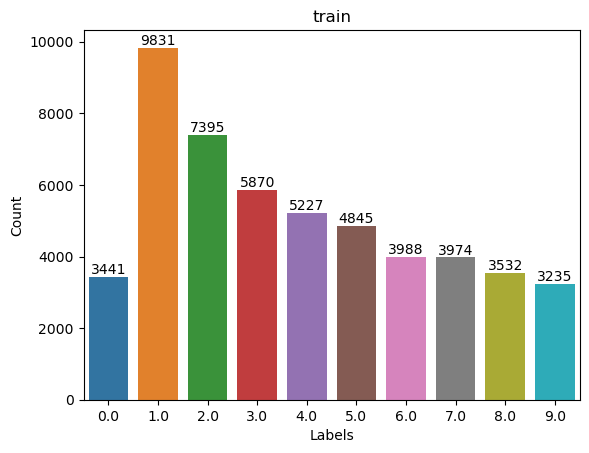

{2.0: 2127, 0.0: 993, 4.0: 1482, 8.0: 1020, 9.0: 970, 5.0: 1380, 3.0: 1739, 1.0: 2695, 6.0: 1147, 7.0: 1094}


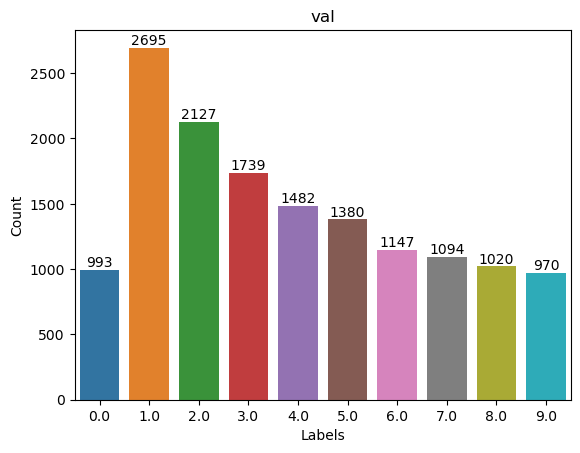

{2.0: 1063, 1.0: 1335, 3.0: 888, 5.0: 657, 8.0: 493, 9.0: 454, 0.0: 514, 7.0: 527, 6.0: 592, 4.0: 749}


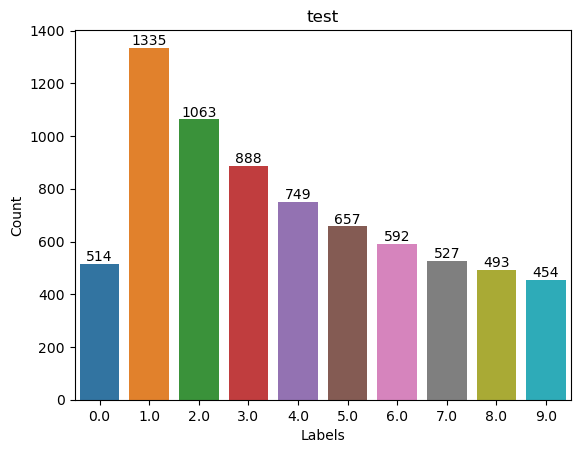

In [ ]:
def plot_bar_graph(dataloader,title):
    dict={}
    for i in range(len(dataloader.dataset)):
        _,label=dataloader.dataset[i]
        if len(label.shape)==1:
            if label[0] in dict:
                dict[label[0]]+=1
            else:
                dict[label[0]]=1
        else:
            for l in label:
                if l[0] in dict:
                    dict[l[0]]+=1
                else:
                    dict[l[0]]=1
    print(dict)
    ax=sns.barplot(x=list(dict.keys()), y=list(dict.values()))
    ax.set(xlabel='Labels', ylabel='Count')
    ax.set_title(title)
    ax.bar_label(ax.containers[0])
    plt.show()
plot_bar_graph(train_loader,"train")
plot_bar_graph(val_loader,"val")
plot_bar_graph(test_loader,"test")

# Q3.2

In [ ]:
for i in range(train_loader.dataset.__len__()):
    image,label=train_loader.dataset[i]
    cv2.imwrite("images/train/"+str(i)+".png",image)
    if len(label.shape)==1:
        label=label.reshape(1,5)
    np.savetxt("labels/train/"+str(i)+".txt",label)
print("Training images and labels saved")
for i in range(val_loader.dataset.__len__()):
    image,label=val_loader.dataset[i]
    cv2.imwrite("images/val/"+str(i)+".png",image)
    if len(label.shape)==1:
        label=label.reshape(1,5)
    np.savetxt("labels/val/"+str(i)+".txt",label)
print("Validation images and labels saved")
for i in range(test_loader.dataset.__len__()):
    image,label=test_loader.dataset[i]
    cv2.imwrite("images/test/"+str(i)+".png",image)
    if len(label.shape)==1:
        label=label.reshape(1,5)
    np.savetxt("labels/test/"+str(i)+".txt",label)
print("Test images and labels saved")

Training images and labels saved
Validation images and labels saved
Test images and labels saved


In [5]:
print(torch.cuda.is_available())
!nvidia-smi

True
Tue Feb 21 05:51:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
!python yolov5/train.py --img 320 --batch 32 --epochs 20 --data coco128.yaml --weights yolov5n.pt --project runs/train --name exp --cache --patience 3 --device 0

wandb: Currently logged in as: sahil20326. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.10
wandb: Run data is saved locally in /content/drive/MyDrive/cv_assignment3_colab/wandb/run-20230216_091633-6oxfom9m
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run youthful-butterfly-38
wandb: ⭐️ View project at https://wandb.ai/sahil20326/CV_assignment_Q3
wandb: 🚀 View run at https://wandb.ai/sahil20326/CV_assignment_Q3/runs/6oxfom9m
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
train: weights=yolov5n.pt, cfg=, data=coco128.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, devi

# part b


In [ ]:
!python yolov5/val.py --weights runs/train/exp9/weights/best.pt --data coco128.yaml --img 320 --task test --verbose --project runs/val --name exp

val: data=/content/drive/MyDrive/cv_assignment3_colab/yolov5/data/coco128.yaml, weights=['runs/train/exp9/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-97-gfa4bdbe Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 1772695 parameters, 0 gradients
test: Scanning /content/drive/MyDrive/cv_assignment3_colab/labels/test.cache... 3341 images, 0 backgrounds, 0 corrupt: 100% 3341/3341 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [00:27<00:00,  3.81it/s]
                   all       3341       7272      0.929      0.901      0.936       0.49
                     0       3341        514      0.941  

In [ ]:
# %ls
%cd ../../

# Q3.3

In [ ]:
import glob
%cd aug/images/test
print(len(glob.glob('*')))
%cd ../../../aug/labels/test
print(len(glob.glob('*')))
%cd ../../../
%ls

In [ ]:
import random
class customDataset(Dataset):
    def __init__(self, images, transform=None):
        self.item = images
        self.transform = transform

    def __len__(self):
        return len(self.item)

    def __getitem__(self, idx):
        item = self.item[idx]
        img=item[0]
        lab=item[1]
        if len(lab.shape)==1:
            lab=lab.reshape(1,5)
        r=random.randint(0,1)
        if r==0:
            img=cv2.flip(img,1)
            for i in lab:
                i[0]=1-i[0]
        r=random.randint(0,1)
        if r==0:
            kernel=np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            img=cv2.filter2D(img,-1,kernel)
        r=random.randint(0,1)
        if r==0:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
            img=cv2.equalizeHist(img[:,:,2])
        if self.transform:
            item[0] = self.transform(item[0])
        return item

In [ ]:
train_size = int(0.7 * len(training_images))
val_size = int(0.2 * len(training_images))
test_size = len(training_images) - train_size - val_size
training_data=customDataset(training_data)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(training_data, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(0))
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
!python yolov5/train.py --img 320 --batch 32 --epochs 10 --hyp hyp.scratch-low.yaml --data coco128.yaml --weights yolov5n.pt --project runs/train --name exp --cache --patience 3 --device 0

wandb: Currently logged in as: sahil20326. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.10
wandb: Run data is saved locally in /content/drive/MyDrive/cv_assignment3_colab/wandb/run-20230221_060114-z04heyla
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fast-field-50
wandb: ⭐️ View project at https://wandb.ai/sahil20326/CV_assignment_Q3
wandb: 🚀 View run at https://wandb.ai/sahil20326/CV_assignment_Q3/runs/z04heyla
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
train: weights=yolov5n.pt, cfg=, data=coco128.yaml, hyp=hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, 

In [11]:
!python yolov5/val.py --weights runs/train/exp19/weights/best.pt --data coco128.yaml --img 320 --task test --verbose --project runs/val --name exp

val: data=/content/drive/MyDrive/cv_assignment3_colab/yolov5/data/coco128.yaml, weights=['runs/train/exp19/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-97-gfa4bdbe Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 1772695 parameters, 0 gradients, 4.2 GFLOPs
test: Scanning /content/drive/MyDrive/cv_assignment3_colab/labels/test.cache... 3341 images, 0 backgrounds, 0 corrupt: 100% 3341/3341 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 105/105 [01:09<00:00,  1.51it/s]
                   all       3341       7272      0.918       0.87       0.92      0.471
                     0       3341        514

In [ ]:
wandb.finish()